In [152]:
import torchvision
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time

class Test(nn.Module):
    def __init__(self):
        super(Test, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Conv2d(32, 32, 5, padding=2),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(1024, 64),
            nn.Linear(64, 100)
        )
 
    def forward(self,x):
        x = self.model(x)
        return x

In [159]:
import torchvision
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time

class Test(nn.Module):
    def __init__(self):
        super(Test, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),
            nn.MaxPool2d(2,2), #32*16*16
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.MaxPool2d(2,2),  # 64*8*8
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, padding=2),
            nn.MaxPool2d(2,2), # 128*4*4
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(128*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 256),            
            nn.ReLU(),
            nn.Linear(256, 100)
        )
 
    def forward(self,x):
        x = self.model(x)
        return x

In [154]:
import torchvision
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
#from model import *
 
# 定义训练设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
# 准备数据集

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_data = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=torchvision.transforms.ToTensor())

test_data = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor())


train_data_size = len(train_data)
test_data_size = len(test_data)
# print("训练数据集的长度为{}".format(train_data_size))
# print("测试数据集的长度为{}".format(test_data_size))
 
# 利用DataLoader来加载数据集
train_dataloader = DataLoader(train_data,batch_size=128)
test_dataloader = DataLoader(test_data,batch_size=128)

Files already downloaded and verified
Files already downloaded and verified


In [155]:
Over_acc=[]
Over_loss=[]

In [156]:
import numpy as np
def cutout(inputs, length=16):
    B, C, H, W = inputs.shape
    mask = np.ones((B, C, H, W), np.float32)
    for i in range(B):
        y = np.random.randint(H)
        x = np.random.randint(W)
        y1 = np.clip(y - length // 2, 0, H)
        y2 = np.clip(y + length // 2, 0, H)
        x1 = np.clip(x - length // 2, 0, W)
        x2 = np.clip(x + length // 2, 0, W)
        mask[i, :, y1:y2, x1:x2] = 0.
    inputs = inputs * torch.from_numpy(mask).to(inputs.device)
    return inputs


def mixup(image, labels, alpha):
    beta = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(image.size()[0])
    image_a = image
    labels_a = labels
    image_b = image[rand_index]
    labels_b = labels[rand_index]
    mixed_image = beta * image_a + (1 - beta) * image_b
    mixed_labels = beta * labels_a + (1 - beta) * labels_b
    return mixed_image, mixed_labels.long()

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(image, labels, alpha):
    beta = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(image.size()[0])
    image_a = image
    labels_a = labels
    image_b = image[rand_index]
    labels_b = labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image.size(), beta)
    image_a[:, bbx1:bbx2, bby1:bby2] = image_b[:, bbx1:bbx2, bby1:bby2]
    labels_a = labels_a * beta + labels_b * (1 - beta)
    labels_a = labels_a.type(torch.LongTensor)
    return image_a, labels_a



In [162]:
print('baseline')
test = Test()
test = test.to(device)
# 损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
 
# 优化器
learning_rate = 0.01
optimizer = torch.optim.SGD(test.parameters(), lr=learning_rate,weight_decay=0.001)
 
# 设置训练网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0
epoch = 30
 
# 添加Tensorboard
writer = SummaryWriter("logs_train")
start_time = time.time()
acclist=[]
losslist=[]
for i in range(epoch):
    print("-----第{}轮训练开始------".format(i+1))
 
    # 训练步骤开始
    test.train()
    for data in train_dataloader:
        imgs,targets = data
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = test(imgs)
        loss = loss_fn(output, targets)
 
        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_train_step += 1
        if total_train_step % 100 == 0:
            end_time = time.time()
            print(end_time - start_time)
            print("训练次数{}, Loss:{}".format(total_train_step, loss.item()))
            writer.add_scalar("train_loss", loss.item(), total_train_step)
 
    # 测试步骤开始
    test.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in test_dataloader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = test(imgs)
            loss = loss_fn(outputs, targets)
            total_test_loss += loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy
    acclist.append(total_accuracy/test_data_size)
    losslist.append(total_test_loss)
    print("整体测试集上的Loss: {}".format(total_test_loss))
    print("整体测试集上的正确率: {}".format(total_accuracy/test_data_size))
    writer.add_scalar("test_loss", total_test_loss, total_test_step)
    writer.add_scalar("test_accuracy", total_accuracy/test_data_size, total_test_step)
    total_test_step += 1
 
    torch.save(test, "baseline_test_{}.pth".format(i))
    print("模型已保存")
    
Over_acc.append(['baseline',acclist])
Over_loss.append(['baseline',losslist])
writer.close()

baseline
-----第1轮训练开始------
63.7651731967926
训练次数100, Loss:4.4768805503845215
114.58752417564392
训练次数200, Loss:4.371220111846924
167.76878595352173
训练次数300, Loss:4.351561069488525
整体测试集上的Loss: 328.85090923309326
整体测试集上的正确率: 0.08699999749660492
模型已保存
-----第2轮训练开始------
237.50718712806702
训练次数400, Loss:4.039119720458984
285.56108593940735
训练次数500, Loss:4.070155143737793
335.5653450489044
训练次数600, Loss:3.8733344078063965
392.23721194267273
训练次数700, Loss:3.898989200592041
整体测试集上的Loss: 295.5408992767334
整体测试集上的正确率: 0.1379999965429306
模型已保存
-----第3轮训练开始------
460.9285740852356
训练次数800, Loss:3.4618937969207764
509.1181619167328
训练次数900, Loss:3.794680595397949
561.4134092330933
训练次数1000, Loss:3.5231924057006836
616.8182690143585
训练次数1100, Loss:3.4663949012756348
整体测试集上的Loss: 281.8996572494507
整体测试集上的正确率: 0.1582999974489212
模型已保存
-----第4轮训练开始------
688.2249250411987
训练次数1200, Loss:3.441863775253296
739.3301730155945
训练次数1300, Loss:3.455264091491699
790.2809700965881
训练次数1400, Loss:3.53689002990

5776.09740114212
训练次数11000, Loss:0.9338144063949585
5818.4447638988495
训练次数11100, Loss:0.7228692173957825
5860.647401094437
训练次数11200, Loss:0.5894017815589905
5902.871963977814
训练次数11300, Loss:0.5814124345779419
整体测试集上的Loss: 264.1119313240051
整体测试集上的正确率: 0.32359999418258667
模型已保存
-----第30轮训练开始------
5957.993743181229
训练次数11400, Loss:0.9246053099632263
6000.3946352005005
训练次数11500, Loss:0.6232380867004395
6042.656486988068
训练次数11600, Loss:0.6092178821563721
6085.104360103607
训练次数11700, Loss:0.6543224453926086
整体测试集上的Loss: 261.65425539016724
整体测试集上的正确率: 0.3285999894142151
模型已保存


In [163]:
print('cutout')
test = Test()
test = test.to(device)
# 损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
 
# 优化器
learning_rate = 0.01
optimizer = torch.optim.SGD(test.parameters(), lr=learning_rate,weight_decay=0.001)
 
# 设置训练网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0
epoch = 30
 
# 添加Tensorboard
writer = SummaryWriter("logs_train")
acclist=[]
losslist=[]
start_time = time.time()
for i in range(epoch):
    print("-----第{}轮训练开始------".format(i+1))
 
    # 训练步骤开始
    test.train()
    for data in train_dataloader:
        imgs,targets = data
        imgs = imgs.to(device)
        imgs=cutout(imgs)
        targets = targets.to(device)
        output = test(imgs)
        a=output
        b=targets
        loss = loss_fn(output, targets)
 
        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_train_step += 1
        if total_train_step % 100 == 0:
            end_time = time.time()
            print(end_time - start_time)
            print("训练次数{}, Loss:{}".format(total_train_step, loss.item()))
            writer.add_scalar("train_loss", loss.item(), total_train_step)
 
    # 测试步骤开始
    test.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in test_dataloader:
            imgs, targets = data
            imgs=cutout(imgs)
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = test(imgs)
            loss = loss_fn(outputs, targets)
            total_test_loss += loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy
    acclist.append(total_accuracy/test_data_size)
    losslist.append(total_test_loss)    
    print("整体测试集上的Loss: {}".format(total_test_loss))
    print("整体测试集上的正确率: {}".format(total_accuracy/test_data_size))
    writer.add_scalar("test_loss", total_test_loss, total_test_step)
    writer.add_scalar("test_accuracy", total_accuracy/test_data_size, total_test_step)
    total_test_step += 1
 
    torch.save(test, "cutout_test_{}.pth".format(i))
    print("模型已保存")
Over_acc.append(['cutout',acclist])
Over_loss.append(['cutout',losslist])
writer.close()


cutout
-----第1轮训练开始------
44.236655712127686
训练次数100, Loss:4.5544328689575195
87.72018194198608
训练次数200, Loss:4.466569900512695
131.37745690345764
训练次数300, Loss:4.437736511230469
整体测试集上的Loss: 339.83363676071167
整体测试集上的正确率: 0.05139999836683273
模型已保存
-----第2轮训练开始------
188.99184679985046
训练次数400, Loss:4.23031759262085
232.81409788131714
训练次数500, Loss:4.229084491729736
276.6457726955414
训练次数600, Loss:4.117054462432861
321.12660789489746
训练次数700, Loss:4.201834678649902
整体测试集上的Loss: 318.35661220550537
整体测试集上的正确率: 0.08479999750852585
模型已保存
-----第3轮训练开始------
378.4904320240021
训练次数800, Loss:3.8747408390045166
422.1341550350189
训练次数900, Loss:3.991565465927124
465.77444410324097
训练次数1000, Loss:3.8215878009796143
509.2169349193573
训练次数1100, Loss:3.8199026584625244
整体测试集上的Loss: 303.6358563899994
整体测试集上的正确率: 0.10670000314712524
模型已保存
-----第4轮训练开始------
566.6012728214264
训练次数1200, Loss:3.696512460708618
610.2520959377289
训练次数1300, Loss:3.801323652267456
653.8616018295288
训练次数1400, Loss:3.8597030639

5462.0283489227295
训练次数11100, Loss:1.9668151140213013
5509.497622728348
训练次数11200, Loss:1.9519970417022705
5558.702445745468
训练次数11300, Loss:1.882975697517395
整体测试集上的Loss: 213.53330397605896
整体测试集上的正确率: 0.33079999685287476
模型已保存
-----第30轮训练开始------
5625.828266859055
训练次数11400, Loss:2.23555850982666
5675.781642913818
训练次数11500, Loss:2.242093563079834
5723.811861991882
训练次数11600, Loss:1.8996626138687134
5774.067161798477
训练次数11700, Loss:2.0370571613311768
整体测试集上的Loss: 211.7948703765869
整体测试集上的正确率: 0.3276999890804291
模型已保存


In [164]:
print('mixup')
test = Test()
test = test.to(device)
# 损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
 
# 优化器
learning_rate = 0.01
optimizer = torch.optim.SGD(test.parameters(), lr=learning_rate,weight_decay=0.001)
 
# 设置训练网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0
epoch = 30
 
# 添加Tensorboard
writer = SummaryWriter("logs_train")
acclist=[]
losslist=[]
start_time = time.time()
for i in range(epoch):
    print("-----第{}轮训练开始------".format(i+1))
 
    # 训练步骤开始
    test.train()
    for data in train_dataloader:
        imgs,targets = data
        r = np.random.rand(1)
        alpha=0.5
        if alpha > 0 and r < 0.5:
            imgs,targets = mixup(imgs, targets, alpha)
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = test(imgs)
        loss = loss_fn(output, targets)
 
        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_train_step += 1
        if total_train_step % 100 == 0:
            end_time = time.time()
            print(end_time - start_time)
            print("训练次数{}, Loss:{}".format(total_train_step, loss.item()))
            writer.add_scalar("train_loss", loss.item(), total_train_step)
 
    # 测试步骤开始
    test.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in test_dataloader:
            imgs, targets = data
            r = np.random.rand(1)
            alpha=0.5
            if alpha > 0 and r < 0.5:
                imgs,targets = mixup(imgs, targets, alpha)
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = test(imgs)
            loss = loss_fn(outputs, targets)
            total_test_loss += loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy
    acclist.append(total_accuracy/test_data_size)
    losslist.append(total_test_loss)
    print("整体测试集上的Loss: {}".format(total_test_loss))
    print("整体测试集上的正确率: {}".format(total_accuracy/test_data_size))
    writer.add_scalar("test_loss", total_test_loss, total_test_step)
    writer.add_scalar("test_accuracy", total_accuracy/test_data_size, total_test_step)
    total_test_step += 1
 
    torch.save(test, "mixup_test_{}.pth".format(i))
    print("模型已保存")
Over_acc.append(['mixup',acclist])
Over_loss.append(['mixup',losslist])
writer.close()

mixup
-----第1轮训练开始------
48.30750632286072
训练次数100, Loss:4.5517778396606445
100.53989219665527
训练次数200, Loss:4.495671272277832
154.10519814491272
训练次数300, Loss:4.567523956298828
整体测试集上的Loss: 350.70635080337524
整体测试集上的正确率: 0.04809999838471413
模型已保存
-----第2轮训练开始------
219.1280870437622
训练次数400, Loss:4.264584541320801
370.31769132614136
训练次数500, Loss:4.288476467132568
475.9948842525482
训练次数600, Loss:4.26127815246582
610.3248131275177
训练次数700, Loss:4.441591739654541
整体测试集上的Loss: 342.8913688659668
整体测试集上的正确率: 0.06689999997615814
模型已保存
-----第3轮训练开始------
757.3521342277527
训练次数800, Loss:4.030179500579834
810.1594672203064
训练次数900, Loss:4.539219856262207
855.1070442199707
训练次数1000, Loss:4.5996503829956055
899.6867301464081
训练次数1100, Loss:4.011557102203369
整体测试集上的Loss: 336.74290680885315
整体测试集上的正确率: 0.08760000020265579
模型已保存
-----第4轮训练开始------
958.6075310707092
训练次数1200, Loss:4.718896389007568
1002.1762611865997
训练次数1300, Loss:4.578597068786621
1046.5679082870483
训练次数1400, Loss:4.57595252990722

5518.715965270996
训练次数11100, Loss:4.543832778930664
5561.420624256134
训练次数11200, Loss:2.5115654468536377
5603.611565113068
训练次数11300, Loss:2.2982847690582275
整体测试集上的Loss: 313.8458080291748
整体测试集上的正确率: 0.14920000731945038
模型已保存
-----第30轮训练开始------
5660.497132062912
训练次数11400, Loss:2.691693067550659
5703.237375020981
训练次数11500, Loss:2.6071746349334717
5745.396149158478
训练次数11600, Loss:2.4876255989074707
5787.913864374161
训练次数11700, Loss:4.732546329498291
整体测试集上的Loss: 297.5277931690216
整体测试集上的正确率: 0.19840000569820404
模型已保存


In [165]:
print('cutmix')
test = Test()
test = test.to(device)
# 损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
 
# 优化器
learning_rate = 0.01
optimizer = torch.optim.SGD(test.parameters(), lr=learning_rate,weight_decay=0.001)
 
# 设置训练网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0
epoch = 30
 
# 添加Tensorboard
writer = SummaryWriter("logs_train")
acclist=[]
losslist=[]
start_time = time.time()
for i in range(epoch):
    print("-----第{}轮训练开始------".format(i+1))
 
    # 训练步骤开始
    test.train()
    for data in train_dataloader:
        imgs,targets = data
        r = np.random.rand(1)
        alpha=0.5
        if alpha > 0 and r < 0.5:
            imgs,targets = cutmix(imgs, targets, alpha)
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = test(imgs)
        loss = loss_fn(output, targets)
        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_train_step += 1
        if total_train_step % 100 == 0:
            end_time = time.time()
            print(end_time - start_time)
            print("训练次数{}, Loss:{}".format(total_train_step, loss.item()))
            writer.add_scalar("train_loss", loss.item(), total_train_step)
 
    # 测试步骤开始
    test.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in test_dataloader:
            imgs, targets = data
            r = np.random.rand(1)
            alpha=0.5
            if alpha > 0 and r < 0.5:
                imgs,targets = cutmix(imgs, targets, alpha)
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = test(imgs)
            loss = loss_fn(outputs, targets)
            total_test_loss += loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy
    acclist.append(total_accuracy/test_data_size)
    losslist.append(total_test_loss)
    print("整体测试集上的Loss: {}".format(total_test_loss))
    print("整体测试集上的正确率: {}".format(total_accuracy/test_data_size))
    writer.add_scalar("test_loss", total_test_loss, total_test_step)
    writer.add_scalar("test_accuracy", total_accuracy/test_data_size, total_test_step)
    total_test_step += 1
 
    torch.save(test, "cutmix_test_{}.pth".format(i))
    print("模型已保存")
Over_acc.append(['cutmix',acclist])
Over_loss.append(['cutmix',losslist])
writer.close()

cutmix
-----第1轮训练开始------


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


42.43056106567383
训练次数100, Loss:4.561559200286865
84.3374330997467
训练次数200, Loss:4.6068925857543945
126.40349912643433
训练次数300, Loss:4.601160526275635
整体测试集上的Loss: 355.1101613044739
整体测试集上的正确率: 0.042100001126527786
模型已保存
-----第2轮训练开始------
181.8232560157776
训练次数400, Loss:4.2852630615234375
224.24575304985046
训练次数500, Loss:4.3460001945495605
266.4303150177002
训练次数600, Loss:4.5144524574279785
309.9710383415222
训练次数700, Loss:4.270928382873535
整体测试集上的Loss: 348.73931884765625
整体测试集上的正确率: 0.05050000175833702
模型已保存
-----第3轮训练开始------
365.51758003234863
训练次数800, Loss:4.053616523742676
407.6850070953369
训练次数900, Loss:4.235929012298584
450.11272501945496
训练次数1000, Loss:4.68592643737793
492.33727622032166
训练次数1100, Loss:4.615508079528809
整体测试集上的Loss: 343.52289485931396
整体测试集上的正确率: 0.06700000166893005
模型已保存
-----第4轮训练开始------
547.725780248642
训练次数1200, Loss:4.029788494110107
590.7344241142273
训练次数1300, Loss:4.035562515258789
633.2523550987244
训练次数1400, Loss:4.115787982940674
675.5602900981903
训练次数

5110.326861143112
训练次数11200, Loss:2.590540885925293
5153.016545057297
训练次数11300, Loss:2.5979180335998535
整体测试集上的Loss: 291.1007556915283
整体测试集上的正确率: 0.22259999811649323
模型已保存
-----第30轮训练开始------
5208.536344051361
训练次数11400, Loss:4.9378509521484375
5252.437664031982
训练次数11500, Loss:4.775766849517822
5295.390413045883
训练次数11600, Loss:2.6113171577453613
5337.859245061874
训练次数11700, Loss:4.8943305015563965
整体测试集上的Loss: 311.664922952652
整体测试集上的正确率: 0.17970000207424164
模型已保存


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


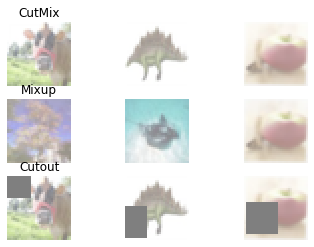

In [166]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('output.pdf')
fig, axs = plt.subplots(3, 3)
row_titles = ['CutMix', 'Mixup', 'Cutout']
for photoindex in range(3):
    for i in range(3):
        dataiter = iter(train_dataloader)
        images, labels = next(dataiter)
        if i==0:
            images, labels = cutmix(images,labels,1)
        elif i==1:
            images, labels = mixup(images,labels,1)
        elif i==2:
            images=cutout(images)
        image=images[photoindex]
        image = image / 2 + 0.5  # unnormalize the image
        image = np.transpose(image, (1, 2, 0))
        axs[i,photoindex].imshow(image)
        axs[i,photoindex].axis('off')
        axs[photoindex, 0].set_title(row_titles[photoindex])
plt.show()
pdf.savefig(fig)

# Closethe PdfPages object
pdf.close()

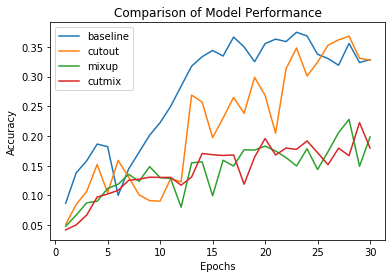

In [173]:
import matplotlib.pyplot as plt

# Define the data for the three models

# Define the x-axis labels
epochs = range(1,30+1)
for labelmodel,acc in Over_acc:
    # Plot the data for each model
    plt.plot(epochs, acc, label=labelmodel)


# Add a title and axis labels
plt.title('Comparison of Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Display the plot
plt.show()

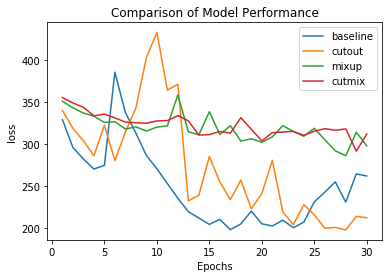

In [176]:
import matplotlib.pyplot as plt

# Define the data for the three models

# Define the x-axis labels
epochs = range(1,epoch+1)
for labelmodel,loss in Over_loss:
    # Plot the data for each model
    plt.plot(epochs,loss , label=labelmodel)


# Add a title and axis labels
plt.title('Comparison of Model Performance')
plt.xlabel('Epochs')
plt.ylabel('loss')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [177]:
Over_loss

[['baseline',
  [328.85090923309326,
   295.5408992767334,
   281.8996572494507,
   269.94188356399536,
   274.23490262031555,
   385.3626537322998,
   337.26847314834595,
   312.84547209739685,
   286.0518283843994,
   270.30299186706543,
   252.6350769996643,
   235.0823357105255,
   219.0118007659912,
   211.48713040351868,
   203.90503692626953,
   209.8707184791565,
   197.54457879066467,
   204.49157238006592,
   219.74203038215637,
   204.64163208007812,
   201.97423386573792,
   208.9601399898529,
   199.96522879600525,
   206.64361667633057,
   230.7935085296631,
   242.29191732406616,
   254.61368417739868,
   230.48917531967163,
   264.1119313240051,
   261.65425539016724]],
 ['cutout',
  [339.83363676071167,
   318.35661220550537,
   303.6358563899994,
   285.75669050216675,
   322.08540892601013,
   279.9744174480438,
   314.05982518196106,
   342.79632568359375,
   402.66767835617065,
   433.03666639328003,
   363.93726921081543,
   371.07306003570557,
   231.935489177703

In [180]:
(50000/128)*30

11718.75